# Load Data

In [5]:
import csv

with open("../data/all_samples_both_instruments_filtered.csv") as f:
    reader = csv.reader(f)
    header = next(reader)[1:]
    sample_names, data = zip(*[(x[0], x[1:]) for x in reader])
    
data = np.asarray(data)

# Distribution of Item Level Data

In [8]:
import plotly.plotly as py
from plotly.graph_objs import *
import plotly
from IPython.display import HTML
import colorlover as cl
import numpy as np

unique, counts = np.unique(data, return_counts=True)
dict(zip(unique, counts/sum(counts)))

py.iplot([Pie(values=counts/sum(counts),
            labels=unique)])


# Concordance of diagnosis with binarized features

In [155]:
import sys
import jsonschema
sys.path.insert(0, '/Users/kelley/Projects/Augur/bin/phenotype/preprocessing')

from assign_diagnosis import assign_all_diagnoses
from collections import defaultdict
import json

# Load schema
with open("../preprocessing/AutismPhenotype.json") as schema_file:    
    pheno_schema = json.load(schema_file)

with open('../data/all_samples_both_instruments.json', 'r') as infile:
    # Read in samples
    samples = json.load(infile)
    
#select entries to binarize
entries = []
for instrument in ['ADIR', 'ADOS', 'ADOS_Module1', 'ADOS_Module2', 'ADOS_Module3', 'ADOS_Module4']:
    for key, value in pheno_schema['definitions'][instrument]['properties'].items():
        if 'data-type' in value and value['data-type'] == 'ordinal':
            if key != 'QB01' and key != 'QA01':
                entries.append((instrument, key))
                  
keys_of_interest = [('ADIR', 'diagnosis', lambda x: x), ('ADOS', 'diagnosis', lambda x: x), 
                    ('ADIR', 'social_interaction', lambda x: x >= 10), ('ADIR', 'communication', lambda x: x >= 7),
                   ('ADIR', 'restricted_repetitive_behavior',  lambda x: x >= 3), ('ADIR', 'abnormality_evident_before_3_years',  lambda x: x >= 1)]

counters = [defaultdict(int) for key in keys_of_interest]
adir_ados_overlap = defaultdict(int)
for sample in samples:
    
    # store original values
    original_values = [key[2](sample[key[0]][key[1]]) for key in keys_of_interest]  
    adir_ados_overlap[(sample['ADIR']['diagnosis'], ('Autism' if sample['ADOS']['diagnosis'] in set(['Autism', 'Autism Spectrum']) else 'Control'))] += 1
    
    # binarize
    for entry in entries:
        if entry[0] in sample and sample[entry[0]][entry[1]] is not None and sample[entry[0]][entry[1]] > 0:
            sample[entry[0]][entry[1]] = 1
                        
    # rediagnose
    assign_all_diagnoses(sample)
    
    # count
    for i, key in enumerate(keys_of_interest):
        counters[i][(original_values[i], key[2](sample[key[0]][key[1]]))] += 1
    
print('ADIR Accuracy', sum([v for k, v in counters[0].items() if k[0] == k[1]])/sum([v for k, v in counters[0].items()]))
print('ADOS Accuracy', sum([v for k, v in counters[1].items() if k[0] == k[1]])/sum([v for k, v in counters[1].items()]))
print('ADIR/ADOS Overlap', sum([v for k, v in adir_ados_overlap.items() if k[0] == k[1]])/sum([v for k, v in adir_ados_overlap.items()]))

for i, key in enumerate(keys_of_interest):
    print(key)
    for key, value in sorted(counters[i].items(), reverse=True):
        print('\t', key, value)
        


ADIR Accuracy 0.666923076923077
ADOS Accuracy 0.8131868131868132
ADIR/ADOS Overlap 0.807032967032967
('ADIR', 'diagnosis', <function <lambda> at 0x10d163c80>)
	 ('Control', 'Control') 1903
	 ('Autism', 'Control') 3031
	 ('Autism', 'Autism') 4166
('ADOS', 'diagnosis', <function <lambda> at 0x12546cae8>)
	 ('Control', 'Control') 885
	 ('Autism Spectrum', 'Control') 180
	 ('Autism Spectrum', 'Autism Spectrum') 768
	 ('Autism', 'Control') 17
	 ('Autism', 'Autism Spectrum') 1503
	 ('Autism', 'Autism') 5747
('ADIR', 'social_interaction', <function <lambda> at 0x12546cbf8>)
	 (True, True) 6765
	 (True, False) 1014
	 (False, False) 1321
('ADIR', 'communication', <function <lambda> at 0x12546ca60>)
	 (True, True) 6420
	 (True, False) 1890
	 (False, False) 790
('ADIR', 'restricted_repetitive_behavior', <function <lambda> at 0x12546cea0>)
	 (True, True) 6679
	 (True, False) 1470
	 (False, False) 951
('ADIR', 'abnormality_evident_before_3_years', <function <lambda> at 0x12546c730>)
	 (True, True) 

So binarizing the features causes our diagnostic algorithm to stop working - not too surpring since it's essentially an additive algorithm.

# New diagnostic algorithm

Can we learn a diagnostic algorithm that is equally effective?

## Logistic regression on original features

In [166]:
import csv
import numpy as np
import random
from collections import Counter

with open("../data/all_samples_both_instruments_filtered.csv") as f:
    reader = csv.reader(f)
    header = next(reader)[1:]
    sample_names, data = zip(*[(x[0], x[1:]) for x in reader])
    
with open("../data/all_samples_both_instruments_filtered_labels.csv") as f:
    reader = csv.reader(f)
    label_header = next(reader)[1:]
    adir_labels, ados_labels, labels = zip(*[(x[2], x[7], x[1:]) for x in reader])
    
num_samples = len(data)
num_features = len(header)
data = np.asarray([[0 if x == 'None' else int(x) for x in row] for row in data])
adir_labels = np.asarray(adir_labels)
ados_labels = np.asarray(ados_labels)
print('All', data.shape, adir_labels.shape, ados_labels.shape, Counter(adir_labels), Counter(ados_labels), sep='\n')

# Split into training and testing
split_percent = .8
train_indices = random.sample(range(num_samples), round(num_samples*split_percent))
test_indices = sorted(set(range(num_samples))-set(train_indices))

train_data = data[train_indices, :]
train_adir_labels = adir_labels[train_indices]
train_ados_labels = ados_labels[train_indices]
print('Train', train_data.shape, train_adir_labels.shape, train_ados_labels.shape, Counter(train_adir_labels), Counter(train_ados_labels), sep='\n')

test_data = data[test_indices, :]
test_adir_labels = adir_labels[test_indices]
test_ados_labels = ados_labels[test_indices]
print('Test', test_data.shape, test_adir_labels.shape, test_ados_labels.shape, Counter(test_adir_labels), Counter(test_ados_labels), sep='\n')


All
(9100, 185)
(9100,)
(9100,)
Counter({'Autism': 7197, 'Control': 1903})
Counter({'Autism': 7267, 'Autism Spectrum': 948, 'Control': 885})
Train
(7280, 185)
(7280,)
(7280,)
Counter({'Autism': 5743, 'Control': 1537})
Counter({'Autism': 5834, 'Autism Spectrum': 741, 'Control': 705})
Test
(1820, 185)
(1820,)
(1820,)
Counter({'Autism': 1454, 'Control': 366})
Counter({'Autism': 1433, 'Autism Spectrum': 207, 'Control': 180})


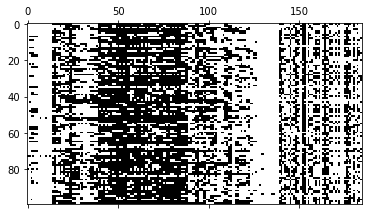

In [167]:
import matplotlib.pyplot as plt
plt.spy(test_data[:100,:])
plt.show()

In [168]:
diagnostic_header = ['ADIR:Q50.2', 'ADIR:Q51.2', 'ADIR:Q57.2', 
    'ADIR:Q49.2', 'ADIR:Q62.2', 'ADIR:Q63.2',
    'ADIR:Q64.2', 'ADIR:Q65.2', 'ADIR:Q52.2', 'ADIR:Q53.2', 'ADIR:Q54.2', 
    'ADIR:Q31.2', 'ADIR:Q55.2', 'ADIR:Q56.2', 'ADIR:Q58.2', 'ADIR:Q59.2',
    'ADIR:Q42.2', 'ADIR:Q43.2', 'ADIR:Q44.2', 'ADIR:Q45.2', 'ADIR:Q30', 
    'ADIR:Q47.2', 'ADIR:Q68.2', 'ADIR:Q61.2', 'ADIR:Q34.2', 'ADIR:Q35.2',
    'ADIR:Q33.2', 'ADIR:Q36.2', 'ADIR:Q37.2', 'ADIR:Q37.2', 'ADIR:Q38.2',
    'ADIR:Q67.2', 'ADIR:Q68.2', 'ADIR:Q70.2', 'ADIR:Q39.2', 'ADIR:Q77.2', 'ADIR:Q78.2', 'ADIR:Q69.2', 'ADIR:Q71.2', 
    'ADIR:Q02', 'ADIR:Q09', 'ADIR:Q10', 'ADIR:Q86', 'ADIR:Q87']
diagnostic_indices = [i for i, x in enumerate(header) if x in set(diagnostic_header)]
adir_indices = [i for i, x in enumerate(header) if x.startswith('ADIR')]
ados_indices = [i for i, x in enumerate(header) if x.startswith('ADOS')]

print(len(diagnostic_indices))

37


## ADIR

In [172]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(fit_intercept=True, max_iter=1000, penalty='l1', C=.048)
print(logreg)
logreg.fit(train_data[:, adir_indices], train_adir_labels)

train_confusion = Counter(zip(train_adir_labels, logreg.predict(train_data[:, adir_indices])))
print('Train')
print('Accuracy', sum([v for k, v in train_confusion.items() if k[0] == k[1]])/sum([v for k, v in train_confusion.items()]), 'Confusion', train_confusion)

test_confusion = Counter(zip(test_adir_labels, logreg.predict(test_data[:, adir_indices])))
print('Test')
print('Accuracy', sum([v for k, v in test_confusion.items() if k[0] == k[1]])/sum([v for k, v in test_confusion.items()]), 'Confusion', test_confusion)

nonzero = [x for i, x in enumerate(np.asarray(header)[adir_indices]) if logreg.coef_[0][i] != 0]
print(len(nonzero))
print(nonzero)
print(len(set(diagnostic_header) & set(nonzero)))



LogisticRegression(C=0.048, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Train
Accuracy 0.9190934065934065 Confusion Counter({('Autism', 'Autism'): 5591, ('Control', 'Control'): 1100, ('Control', 'Autism'): 437, ('Autism', 'Control'): 152})
Test
Accuracy 0.9159340659340659 Confusion Counter({('Autism', 'Autism'): 1420, ('Control', 'Control'): 247, ('Control', 'Autism'): 119, ('Autism', 'Control'): 34})
50
['ADIR:Q30', 'ADIR:Q31.2', 'ADIR:Q33.1', 'ADIR:Q33.2', 'ADIR:Q35.1', 'ADIR:Q35.2', 'ADIR:Q36.2', 'ADIR:Q37.2', 'ADIR:Q38.2', 'ADIR:Q39.2', 'ADIR:Q42.2', 'ADIR:Q43.2', 'ADIR:Q44.2', 'ADIR:Q45.2', 'ADIR:Q46.1', 'ADIR:Q47.2', 'ADIR:Q48.2', 'ADIR:Q49.1', 'ADIR:Q49.2', 'ADIR:Q50.1', 'ADIR:Q50.2', 'ADIR:Q51.2', 'ADIR:Q52.2', 'ADIR:Q53.2', 'ADIR:Q54.2', 'ADIR:Q55.1', 'ADIR:Q55.2', 'ADIR:Q56.2', 'ADIR

In [10]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(fit_intercept=True, max_iter=1000, penalty='l1', C=.07)
logreg.fit(train_data[:, adir_indices]>0, train_adir_labels)

train_confusion = Counter(zip(train_adir_labels, logreg.predict(train_data[:, adir_indices]>0)))
print('Train')
print('Accuracy', sum([v for k, v in train_confusion.items() if k[0] == k[1]])/sum([v for k, v in train_confusion.items()]), 'Confusion', train_confusion)

test_confusion = Counter(zip(test_adir_labels, logreg.predict(test_data[:, adir_indices]>0)))
print('Test')
print('Accuracy', sum([v for k, v in test_confusion.items() if k[0] == k[1]])/sum([v for k, v in test_confusion.items()]), 'Confusion', test_confusion)

nonzero = [x for i, x in enumerate(np.asarray(header)[adir_indices]) if logreg.coef_[0][i] != 0]
print(len(nonzero))
print(nonzero)
print(len(set(diagnostic_header) & set(nonzero)))

NameError: name 'train_data' is not defined

In [9]:
train_probs = logreg.predict_proba(train_data[:, adir_indices]>0)

NameError: name 'logreg' is not defined

## ADOS

In [194]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(fit_intercept=True, max_iter=1000, penalty='l1', C=.057)
print(logreg)
logreg.fit(train_data[:, ados_indices], ['Autism' if x.startswith('Autism') else 'Control' for x in train_ados_labels])

train_confusion = Counter(zip(['Autism' if x.startswith('Autism') else 'Control' for x in train_ados_labels], logreg.predict(train_data[:, ados_indices])))
print('Train')
print('Accuracy', sum([v for k, v in train_confusion.items() if k[0] == k[1]])/sum([v for k, v in train_confusion.items()]), 'Confusion', train_confusion)

test_confusion = Counter(zip(['Autism' if x.startswith('Autism') else 'Control' for x in test_ados_labels], logreg.predict(test_data[:, ados_indices])))
print('Test')
print('Accuracy', sum([v for k, v in test_confusion.items() if k[0] == k[1]])/sum([v for k, v in test_confusion.items()]), 'Confusion', test_confusion)

nonzero = [x for i, x in enumerate(np.asarray(header)[ados_indices]) if logreg.coef_[0][i] != 0]
print(len(nonzero))
print(nonzero)



LogisticRegression(C=0.057, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Train
Accuracy 0.9760989010989011 Confusion Counter({('Autism', 'Autism'): 6563, ('Control', 'Control'): 543, ('Control', 'Autism'): 162, ('Autism', 'Control'): 12})
Test
Accuracy 0.9730769230769231 Confusion Counter({('Autism', 'Autism'): 1639, ('Control', 'Control'): 132, ('Control', 'Autism'): 48, ('Autism', 'Control'): 1})
25
['ADOS:QA02', 'ADOS:QA03', 'ADOS:QA04', 'ADOS:QA06', 'ADOS:QA07', 'ADOS:QA08', 'ADOS:QA09', 'ADOS:QA10', 'ADOS:QA13', 'ADOS:QB01', 'ADOS:QB02', 'ADOS:QB04', 'ADOS:QB05', 'ADOS:QB06', 'ADOS:QB08', 'ADOS:QB10', 'ADOS:QB12', 'ADOS:QB13', 'ADOS:QB14', 'ADOS:QB15', 'ADOS:QB16', 'ADOS:QD01', 'ADOS:QD02', 'ADOS:QD04', 'ADOS:QD05']


In [196]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(fit_intercept=True, max_iter=1000, penalty='l1', C=.08)
print(logreg)
logreg.fit(train_data[:, ados_indices]>0, ['Autism' if x.startswith('Autism') else 'Control' for x in train_ados_labels])

train_confusion = Counter(zip(['Autism' if x.startswith('Autism') else 'Control' for x in train_ados_labels], logreg.predict(train_data[:, ados_indices]>0)))
print('Train')
print('Accuracy', sum([v for k, v in train_confusion.items() if k[0] == k[1]])/sum([v for k, v in train_confusion.items()]), 'Confusion', train_confusion)

test_confusion = Counter(zip(['Autism' if x.startswith('Autism') else 'Control' for x in test_ados_labels], logreg.predict(test_data[:, ados_indices]>0)))
print('Test')
print('Accuracy', sum([v for k, v in test_confusion.items() if k[0] == k[1]])/sum([v for k, v in test_confusion.items()]), 'Confusion', test_confusion)

nonzero = [x for i, x in enumerate(np.asarray(header)[ados_indices]) if logreg.coef_[0][i] != 0]
print(len(nonzero))
print(nonzero)



LogisticRegression(C=0.08, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Train
Accuracy 0.9743131868131868 Confusion Counter({('Autism', 'Autism'): 6554, ('Control', 'Control'): 539, ('Control', 'Autism'): 166, ('Autism', 'Control'): 21})
Test
Accuracy 0.967032967032967 Confusion Counter({('Autism', 'Autism'): 1630, ('Control', 'Control'): 130, ('Control', 'Autism'): 50, ('Autism', 'Control'): 10})
25
['ADOS:QA02', 'ADOS:QA03', 'ADOS:QA04', 'ADOS:QA06', 'ADOS:QA07', 'ADOS:QA08', 'ADOS:QA09', 'ADOS:QA10', 'ADOS:QA11', 'ADOS:QA13', 'ADOS:QB01', 'ADOS:QB02', 'ADOS:QB04', 'ADOS:QB05', 'ADOS:QB08', 'ADOS:QB10', 'ADOS:QB12', 'ADOS:QB13', 'ADOS:QB14', 'ADOS:QB15', 'ADOS:QB16', 'ADOS:QD01', 'ADOS:QD02', 'ADOS:QD04', 'ADOS:QD05']
